# Analysing data

After the data has been prepared in the Preparing data notebook, we can now start analysing the data. 

### Importing libraries

In [321]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from Project.Helpers.Classes import User

### Figure Functions

In [322]:
def get_running_frequencies(classifications):
    # Get the unique categories
    categories = classifications['remapped_parent_classification'].unique()
    
    # Initialize a dictionary to hold the running frequencies for each category
    running_frequencies = {category: [] for category in categories}
    total_videos = {category: [] for category in categories}
    window_size = 100
    positive_frequency = []
    negative_frequency = []
    
    
    # Calculate running watch/like frequency
    for i in range(len(classifications['reaction'])):
        # Determine the start of the window
        start_index = max(0, i - window_size + 1)
        # Slice the window from the reactions list
        positive_window = classifications['positive'][start_index:i+1]
        negative_window = classifications['negative'][start_index:i+1]
        # Calculate the sum of the window (number of occurrences of the reaction in the window)
        count_positive = sum(positive_window)
        count_negative = sum(negative_window)
        
        # Calculate the average frequency
        average_frequency_positive = count_positive / min(i + 1, window_size)
        positive_frequency.append(average_frequency_positive)
        
        average_frequency_negative = count_negative / min(i + 1, window_size)
        negative_frequency.append(average_frequency_negative)
    
    
    smooth_positive_frequency = pd.Series(positive_frequency)
    smooth_positive_frequency = smooth_positive_frequency.rolling(window=5).mean()
    
    smooth_negative_frequency = pd.Series(negative_frequency)
    smooth_negative_frequency = smooth_negative_frequency.rolling(window=5).mean()
    
    # Calculate running frequencies for each category
    for i, category in enumerate(classifications['remapped_parent_classification'], start=1):
        for cat in categories:
            
            if cat == category:
                total_videos[cat].append(1)
            else:
                total_videos[cat].append(0)
            
            # Determine the start of the window
            start_index = max(0, i - window_size)
            # Slice the window from the total_videos list for the current category
            window = total_videos[cat][start_index:i]
            # Calculate the sum of the window (number of occurrences of the category in the window)
            count_cat = sum(window)
            # Calculate the average frequency
            average_frequency = count_cat / min(window_size, i)
            running_frequencies[cat].append(average_frequency)
            
            
    # Determine if the category has majority positive reactions
    category_is_positive_dict = classifications.groupby('remapped_parent_classification')['positive'].mean().apply(lambda x: x > 0.5).to_dict()
    
    return running_frequencies, category_is_positive_dict, smooth_positive_frequency, smooth_negative_frequency, window_size

In [323]:
def plot_time_analysis(classifications, username):    
    parent_category_order = classifications['remapped_parent_classification'].unique().tolist()
    plt.figure(figsize=(16, 8))  # Increase the figure size
    
    run_type = user.username.split('percent')[-1]
    if run_type[-1] not in ['r', 'l']:
        run_type = run_type[:-1]
    run_name = f'{run_type.capitalize()} Frequency {user.username.split("percent")[0]}%'
    
    # make the dots color coded based on if they are watched
    
    plt.scatter(classifications.index, classifications["remapped_parent_classification"], s=10, color=classifications['positive'].map({0: 'red', 1: 'green'}))
    plt.yticks(range(len(parent_category_order)), parent_category_order)
    plt.xlabel('Video Number')
    plt.ylabel('Category')
    plt.title(f'Time Analysis of Video Categories for {run_name}')
    plt.savefig(f'../Output_data/figures/category_time_analysis_{username}.png')
    plt.show()

In [324]:
def plot_positive_classifications_frequencies(classifications, username):
    running_frequencies, category_is_positive_dict, smooth_positive_frequency, smooth_negative_frequency, window_size = get_running_frequencies(classifications)
    
    # Plot the running frequencies for all categories
    plt.figure(figsize=(10, 6))  # Increase the figure size
    
    for category, frequencies in running_frequencies.items():
        
            # Assuming positive_frequency and negative_frequency are your data
        smooth_frequencies = pd.Series(frequencies)
        
        smooth_frequencies = smooth_frequencies.rolling(window=5).mean()
    
    
        if category_is_positive_dict[category]:
            plt.plot(range(1, len(smooth_frequencies) + 1), smooth_frequencies, linestyle='-', label=category)
    
    run_type = user.username.split('percent')[-1]
    if run_type[-1] not in ['r', 'l']:
        run_type = run_type[:-1]
    run_name = f'{run_type.capitalize()} Frequency {user.username.split("percent")[0]}%'
    
    plt.plot(range(1, len(smooth_positive_frequency) + 1), smooth_positive_frequency, linestyle='-', label='Positive Frequency', linewidth=2, color='green')
    #plt.plot(range(1, len(negative_frequency) + 1), negative_frequency, linestyle='-', label='Negative Frequency', linewidth=2)
    plt.xlabel('Number of Videos')
    plt.ylabel('Average Frequency')
    plt.title(f'Running Average Frequency of Each Category Over the Last {window_size} Rows for {run_name}')
    plt.legend(title='Categories', loc='upper left', ncol=1)  # Position legend outside the plot
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to make room for the legend
    plt.savefig(f'../Output_data/figures/positive_category_running_frequencies_{username}.png')
    
    plt.show()

In [325]:
def plot_negative_classifications_frequencies(classifications, username):
    running_frequencies, category_is_positive_dict, smooth_positive_frequency, smooth_negative_frequency, window_size = get_running_frequencies(classifications)
    
    # Plot the running frequencies for all categories
    plt.figure(figsize=(16, 8))  # Increase the figure size
    
    for category, frequencies in running_frequencies.items():
        
            # Assuming positive_frequency and negative_frequency are your data
        smooth_frequencies = pd.Series(frequencies)
        
        smooth_frequencies = smooth_frequencies.rolling(window=5).mean()
    
    
        if not category_is_positive_dict[category]:
            plt.plot(range(1, len(smooth_frequencies) + 1), smooth_frequencies, linestyle='-', label=category)
    
    run_type = user.username.split('percent')[-1]
    if run_type[-1] not in ['r', 'l']:
        run_type = run_type[:-1]
    run_name = f'{run_type.capitalize()} Frequency {user.username.split("percent")[0]}%'
    
    #plt.plot(range(1, len(smooth_positive_frequency) + 1), smooth_positive_frequency, linestyle='-', label=label, linewidth=2)
    plt.plot(range(1, len(smooth_negative_frequency) + 1), smooth_negative_frequency, linestyle='-', label='Negative Frequency', linewidth=2, color = 'red')
    plt.xlabel('Number of Videos')
    plt.ylabel('Average Frequency')
    plt.title(f'Running Average Frequency of Each Category Over the Last {window_size} Rows for {run_name}')
    plt.legend(title='Categories', loc='upper left', ncol=1)  # Position legend outside the plot
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to make room for the legend
    plt.savefig(f'../Output_data/figures/negative_category_running_frequencies_{username}.png')
    
    plt.show()

In [326]:
def obtain_positive_category_percentages(classifications, username):
    count_positives = classifications.groupby('remapped_parent_classification')['positive'].sum()
    count_total = classifications['positive'].sum()
    percentages = count_positives / count_total
    percentages = percentages.sort_values(ascending=False)
    # filter out the categories that have less than 0% of the total positive classifications
    percentages = percentages[percentages > 0]
    percentages = percentages * 100
    percentages = percentages.round(2)
    percentages = percentages[:6]
    
    
    run_type = user.username.split('percent')[-1]
    if run_type[-1] not in ['r', 'l']:
        run_type = run_type[:-1]
    run_name = f'{run_type.capitalize()} Frequency {user.username.split("percent")[0]}%'
    
    plt.bar(percentages.index, percentages)
    plt.xticks(rotation=90)
    plt.ylabel('Percentage of Positive Classifications')
    plt.title(f'Positive Classifications Percentage for Each Category for {run_name}')
    plt.tight_layout()
    plt.savefig(f'../Output_data/figures/positive_category_percentages_{username}.png')
    # plt.show()
    
    return percentages

### Load users

In [327]:
with open('../Input_data/users.json') as f:
    users = json.load(f)
    
users = [User(user) for user in users]

users.sort(key=lambda x: int(x.username.split('percent')[0]))
users.sort(key=lambda x: x.username.split('percent')[-1])

print('ID \t Username')
for user in users:
    username = user.username.split('percent')
    print(f'{user.id} \t {username[0]}% {username[-1]}')

ID 	 Username
22 	 100% all
14 	 10% disliker
15 	 50% disliker
16 	 100% disliker
24 	 10% disliker2
25 	 100% disliker2
7 	 10% liker
8 	 25% liker
9 	 50% liker
10 	 75% liker
11 	 100% liker
13 	 100% liker2
23 	 100% liker3
27 	 100% liker4
17 	 10% sharer
18 	 25% sharer
19 	 50% sharer
20 	 75% sharer
21 	 100% sharer
26 	 10% sharer2
28 	 100% skipper
3 	 10% watcher
4 	 25% watcher
5 	 50% watcher
6 	 75% watcher
2 	 100% watcher
12 	 75% watcher2


### Chose the users

In [328]:
user_ids = [5, 12, 2]
# user_ids = [2]
users_to_analyze = [user for user in users if user.id in user_ids]

### Excute the functions

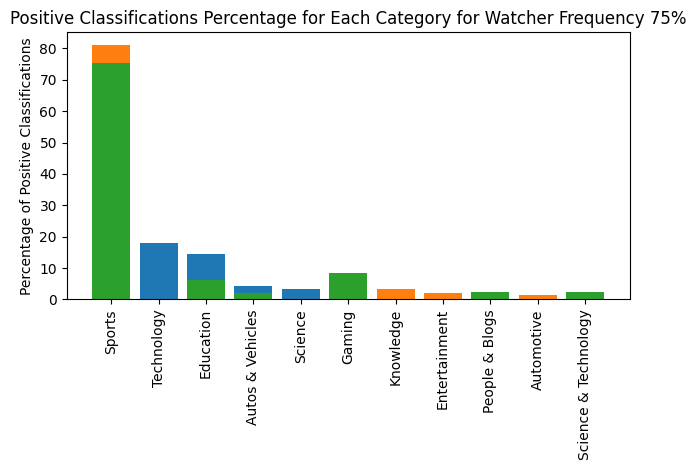

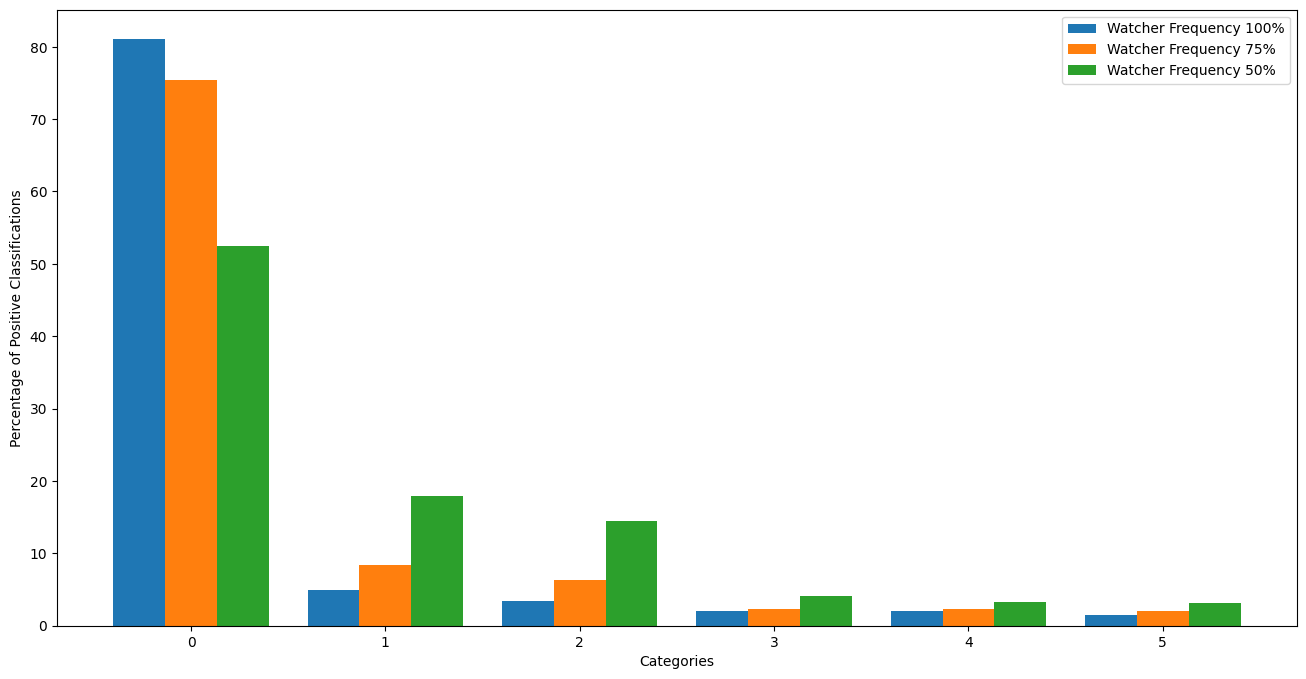

In [329]:
percentages_dict = {}


for user in users_to_analyze:
    username = user.username
    data_path = f'../Output_data/classifications_{username}.csv'
    classifications = pd.read_csv(data_path)
    # plot_time_analysis(classifications, username)
    # plot_positive_classifications_frequencies(classifications, username)
    # plot_negative_classifications_frequencies(classifications, username)
    percentages = obtain_positive_category_percentages(classifications, username)
    percentages_dict[username] = percentages
    # print(f'Positive category percentages for {username}')
    
percentages_df = pd.DataFrame()

plt.figure(figsize=(16, 8))

# Number of users
n_users = len(percentages_dict)
bar_width = 0.8 / n_users  # Width of each bar

user_order = ['100percentwatcher', '75percentwatcher2', '50percentwatcher']

# Indices for the bars
indices = np.arange(len(next(iter(percentages_dict.values())).index))

for i, user in enumerate(user_order):
    percentage = percentages_dict[user].reset_index()
    percentages_df[user] = percentage['positive']
    run_type = user.split('percent')[-1]
    if run_type[-1] not in ['r', 'l']:
        run_type = run_type[:-1]
    run_name = f'{run_type.capitalize()} Frequency {user.split("percent")[0]}%'
    plt.bar(indices + i * bar_width, percentages_df[user], bar_width, label=run_name)

    
plt.xlabel('Categories')
plt.ylabel('Percentage of Positive Classifications')
plt.xticks(indices + bar_width * (n_users - 1) / 2, percentages_df.index)
plt.legend()
plt.savefig(f'../Output_data/figures/positive_category_percentages_comparison_watch.png')
plt.show()
    
    